In [44]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, KFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [45]:
# Get current working directory
cwd = os.getcwd()

def load_file(filepath: str) -> pd.DataFrame:
    # Check if file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError("File not found")
    
    # Read file
    try:
        df = pd.read_csv(filepath, skiprows=2, header=0, sep=",", decimal=".")
    except:
        return None
    

    # Make new column with entire filepath, and another with just the filename
    df["filepath"] = '/'.join(filepath.split(os.sep)[-2:])
    df["filename"] = os.path.basename(filepath)
    df["label"] = filepath.split(os.sep)[-2].split("-")[-1]

    return df

def get_all_data(data_folder) -> pd.DataFrame:
    # Check if folder exists
    if not os.path.exists(data_folder):
        raise FileNotFoundError("Folder not found")

    # Check if cwd is part of data_folder
    if not data_folder.startswith(cwd):
        # If not, add cwd to data_folder
        data_folder = os.path.join(cwd, data_folder)

    # Get all csv files from subfolders of data_folder
    dfs = []
    for root, dirs, filenames in os.walk(data_folder):
        # if "Merged" in any filenames only take that csv file
        if any("Merged" in f for f in filenames):
            filenames = [f for f in filenames if "Merged" in f]
            for f in filenames:
                if f.endswith(".CSV"):
                    df = load_file(os.path.join(root, f))
                    if df is not None:
                        dfs.append(df)
        else:
            for f in filenames:
                if f.endswith(".CSV"):
                    df = load_file(os.path.join(root, f))
                    if df is not None:
                        dfs.append(df)                
    
    # Concatenate all dataframes
    df = pd.concat(dfs, ignore_index=True)
    return df
    

## Load data

In [46]:
# Load data
df = get_all_data("../../data/raw")

### Simple stats

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192840 entries, 0 to 3192839
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   millis    int64  
 1   x         float64
 2   y         float64
 3   z         float64
 4   filepath  object 
 5   filename  object 
 6   label     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 170.5+ MB


In [48]:
df.head()

,millis,x,y,z,filepath,filename,label
0,8028,-0.26,1.76,0.77,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
1,8028,-0.31,1.32,0.82,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
2,8028,0.03,1.18,1.01,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
3,8028,-0.26,1.52,0.77,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
4,8028,-0.07,1.32,0.72,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting


In [49]:
df.label.value_counts()

Missing_Idle       898800
Broken_Cutting     709800
Healthy_Cutting    663600
Healthy_Idle       633360
Broken_Idle        149520
Missing_Cutting    137760
Name: label, dtype: int64

In [120]:
df.groupby("label")[df.columns.difference(["millis"])].describe().T

label    Broken_Cutting    Broken_Idle  Healthy_Cutting   Healthy_Idle  \
x count   708000.000000  144000.000000    660000.000000  630000.000000   
  mean         0.033962      -0.119110         0.046935      -0.032314   
  std          0.578170       0.467258         0.528255       0.315301   
  min        -17.070000      -2.670000       -22.610000      -1.490000   
  25%         -0.220000      -0.410000        -0.260000      -0.260000   
  50%          0.030000      -0.120000         0.030000      -0.020000   
  75%          0.320000       0.130000         0.320000       0.180000   
  max         21.790000       2.230000        13.750000       1.500000   
y count   708000.000000  144000.000000    660000.000000  630000.000000   
  mean         1.369306       1.294733         1.355109       1.358925   
  std          0.703917       0.846279         0.684541       0.572883   
  min        -13.280000      -3.720000       -12.980000      -0.390000   
  25%          0.980000       0.690000         0.930000       0.880000   
  50%          1.320000       1.320000         1.320000       1.370000   
  75%          1.720000       1.910000         1.760000       1.810000   
  max         19.010000       6.810000        15.680000       3.040000   
z count   708000.000000  144000.000000    660000.000000  630000.000000   
  mean         0.511643       0.529080         0.686642       0.676031   
  std          0.669750       0.474707         0.602121       0.254015   
  min        -16.530000      -1.930000        -9.820000      -0.750000   
  25%          0.180000       0.280000         0.330000       0.520000   
  50%          0.520000       0.570000         0.720000       0.670000   
  75%          0.820000       0.820000         1.010000       0.820000   
  max         14.490000       2.780000        21.540000       2.090000   

label    Missing_Cutting   Missing_Idle  
x count    132000.000000  894000.000000  
  mean          0.046779      -1.231734  
  std           2.374915       6.567871  
  min         -25.740000     -25.740000  
  25%          -0.950000      -2.130000  
  50%           0.080000      -2.130000  
  75%           1.110000      -0.710000  
  max          24.380000     880.850000  
y count    132000.000000  894000.000000  
  mean          1.373182       3.811374  
  std           3.451265       7.176031  
  min         -24.700000     -24.700000  
  25%          -0.440000       3.630000  
  50%           1.370000       5.390000  
  75%           3.330000       5.390000  
  max          25.430000     881.900000  
z count    132000.000000  894000.000000  
  mean          0.570923      -0.895586  
  std           3.250623       2.418733  
  min         -24.370000     -24.370000  
  25%          -1.000000      -1.980000  
  50%           0.520000      -1.980000  
  75%           2.040000      -0.160000  
  max          25.760000      21.790000

### Split each group into small parts

In [50]:
def split_dataframe(df, name, chunk_size = 6000): # 4000 is 5 seconds of data
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunk = df[i*chunk_size:(i+1)*chunk_size]
        chunk["group"] = f"{name}_{i}"
        chunks.append(chunk)
    return chunks

In [51]:
df_parts = []
for name, group in df.groupby("label"):
    groups = split_dataframe(group, name)

    # throw away last group if it is too small
    if len(groups[-1]) < 6000:
        groups.pop()
    
    df_parts.append(pd.concat(groups))
df = pd.concat(df_parts)

In [52]:
df.head()

,millis,x,y,z,filepath,filename,label,group
1562400,7518,0.37,1.08,-0.02,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562401,7518,0.03,1.86,-0.02,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562402,7518,-0.36,1.72,0.47,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562403,7518,-0.90,2.16,0.03,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562404,7518,-0.46,0.83,0.67,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0


In [53]:
# Save data to processed folder
df.to_parquet("../../data/processed/processed.parquet")
del df

### Load data from processed

In [54]:
# Load data from processed
df = pd.read_parquet("../../data/processed/processed.parquet")
df.head()

,millis,x,y,z,filepath,filename,label,group
1562400,7518,0.37,1.08,-0.02,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562401,7518,0.03,1.86,-0.02,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562402,7518,-0.36,1.72,0.47,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562403,7518,-0.90,2.16,0.03,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0
1562404,7518,-0.46,0.83,0.67,Test 10-Broken_Cutting/Test 10 - Merged.CSV,Test 10 - Merged.CSV,Broken_Cutting,Broken_Cutting_0


## Split data in train and test

In [57]:
from typing import Union

def split_grouped_data(df: pd.DataFrame, time_series_splitter: Union[TimeSeriesSplit, KFold]) -> list:
    # Drop columns that are not needed
    df = df.drop(columns=["millis", "filepath", "filename", "group"])

    # Split into train and test
    train_splits, test_splits = time_series_splitter.split(df)
    return train_splits, test_splits

def split_data(df: pd.DataFrame, n_splits: int = 2, groupby_cols=["group"]) -> list:
    # Split into train and test for each group
    train_splits, train_labels, test_splits, test_labels = [], [], [], []
    tss = KFold(n_splits=n_splits)

    # Split data into groups and then split into test and train
    for name, group in tqdm(df.groupby(groupby_cols)):
        # Split into train and test
        test_split, train_split = split_grouped_data(df=group, time_series_splitter=tss)
        
        # Get train and test data
        train_data = group.iloc[train_split[0], :]
        test_data = group.iloc[test_split[0], :]
        
        # Append to list
        train_splits.append(train_data[["x", "y", "z"]])
        test_splits.append(test_data[["x", "y", "z"]])
        train_labels.append(train_data["label"])
        test_labels.append(test_data["label"])
    return train_splits, test_splits, train_labels, test_labels
    

In [58]:
train_splits, test_splits, train_labels, test_labels = split_data(df, n_splits=2, groupby_cols=["group"])

100%|██████████| 528/528 [00:01<00:00, 432.33it/s]


In [59]:
print(len(train_splits[0]))
print(len(test_splits[0]))

3000
3000


In [60]:
train_labels[0].iloc[0]

'Broken_Cutting'

### Create datasets

In [61]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

batch_size = 32

def create_datasets_from_splits(splits, labels):
    iterable_datasets = []
    for split in splits:
        # Create pytorch dataset from split
        dataset = torch.tensor(split.values, dtype=torch.float32)
        iterable_datasets.append(dataset)
    
    # create dataloader from iterable_datasets
    return torch.utils.data.DataLoader(iterable_datasets, batch_size=batch_size, shuffle=False)


In [62]:
train_dataloader = create_datasets_from_splits(train_splits, train_labels)
test_dataloader = create_datasets_from_splits(test_splits, test_labels)

Enumerate labels

In [63]:
id_to_label = dict(enumerate(set([x.iloc[0] for x in train_labels])))
label_to_id = {v: k for k, v in id_to_label.items()}

In [64]:
for i, d in enumerate(train_dataloader):
    print(d.shape)
    break

torch.Size([32, 3000, 3])


### Convolutional model

In [65]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)


class Classifier(nn.Module):
    def __init__(self, input_dim, number_of_classes, drop=.1):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(input_dim,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(5888, 1024), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(1024, 512), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 512, 128), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, number_of_classes))
        
    def forward(self, input_):
        # reorder dimensions to (batch_size, channels, sequence_length)
        input_ = input_.permute(0, 2, 1)
        raw_out = self.raw(input_)
        out = self.out(raw_out)
        return out

## Train


In [66]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
lr = 0.001
n_epochs = 4000
iterations_per_epoch = len(train_dataloader)
num_classes = len(id_to_label)
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []
drop = 0.25
drop_str = str(drop).replace('.', '_')


model_name = 'cnn'
if model_name == 'cnn':
    model = Classifier(3, num_classes, drop=drop).to(device)


criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_dataloader):
        input = batch.to(device)
        label = torch.tensor([label_to_id[train_labels[(i*batch_size)+b-1].iloc[0]] for b in range(len(batch))]).to(device)
        assert len(input) == len(label)
        opt.zero_grad()
        output = model(input)
        loss = criterion(output, label)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= iterations_per_epoch
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for i, batch in enumerate(test_dataloader):
        input = batch.to(device)
        label = torch.tensor([label_to_id[train_labels[(i*batch_size)+b-1].iloc[0]] for b in range(len(batch))]).to(device)
        assert len(input) == len(label)
        output = model(input)
        preds = F.log_softmax(output, dim=1).argmax(dim=1)
        total += batch_size
        correct += (preds == label).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), f'models/best–model{model_name}-lr{lr}-batch{batch_size}.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 61.9466. Acc.: 21.69%
Epoch 1 best model saved with accuracy: 21.69%
Epoch:   2. Loss: 56.2976. Acc.: 21.69%
Epoch:   4. Loss: 55.2744. Acc.: 21.69%
Epoch 5 best model saved with accuracy: 21.88%
Epoch 7 best model saved with accuracy: 27.39%
Epoch:   8. Loss: 47.9344. Acc.: 27.39%
Epoch 9 best model saved with accuracy: 48.90%
Epoch:  16. Loss: 41.3334. Acc.: 48.90%
Epoch:  32. Loss: 30.5388. Acc.: 48.90%
Epoch 44 best model saved with accuracy: 49.82%
Epoch 53 best model saved with accuracy: 58.64%
Epoch 60 best model saved with accuracy: 67.83%
Epoch:  64. Loss: 33.5242. Acc.: 66.54%
Epoch 70 best model saved with accuracy: 71.51%
Epoch 79 best model saved with accuracy: 72.98%
Epoch 83 best model saved with accuracy: 73.35%
Epoch 92 best model saved with accuracy: 73.53%
Epoch 101 best model saved with accuracy: 75.00%
Epoch 112 best model saved with accuracy: 75.55%
Epoch 115 best model saved with accuracy: 75.74%
Epoch: 128. Loss: 11.6276. A

## Plots

In [68]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

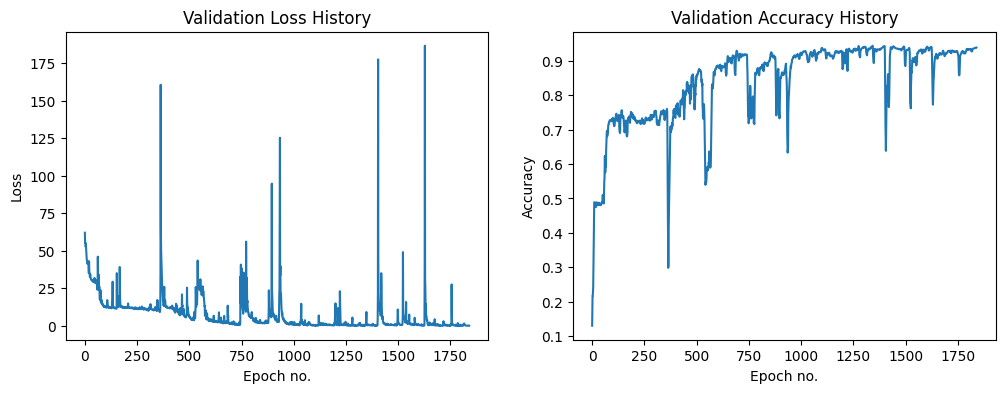

In [69]:

f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

plt.savefig(f'plots/loss-model{model_name}-lr{lr}-batch{batch_size}-drop{drop_str}.png')

### Confusion matrix

In [70]:
test_results = []
model.load_state_dict(torch.load(f'models/best–model{model_name}-lr{lr}-batch{batch_size}.pth'))
model.eval()
for input_ in test_dataloader:
    input_ = input_.to(device)
    out = model(input_)
    output = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(output.detach().cpu().numpy())

In [71]:
len(test_results)

528

In [72]:
label_to_id.keys()

dict_keys(['Missing_Cutting', 'Missing_Idle', 'Healthy_Cutting', 'Broken_Cutting', 'Healthy_Idle', 'Broken_Idle'])

In [73]:
list(label_to_id.keys())

['Missing_Cutting',
 'Missing_Idle',
 'Healthy_Cutting',
 'Broken_Cutting',
 'Healthy_Idle',
 'Broken_Idle']

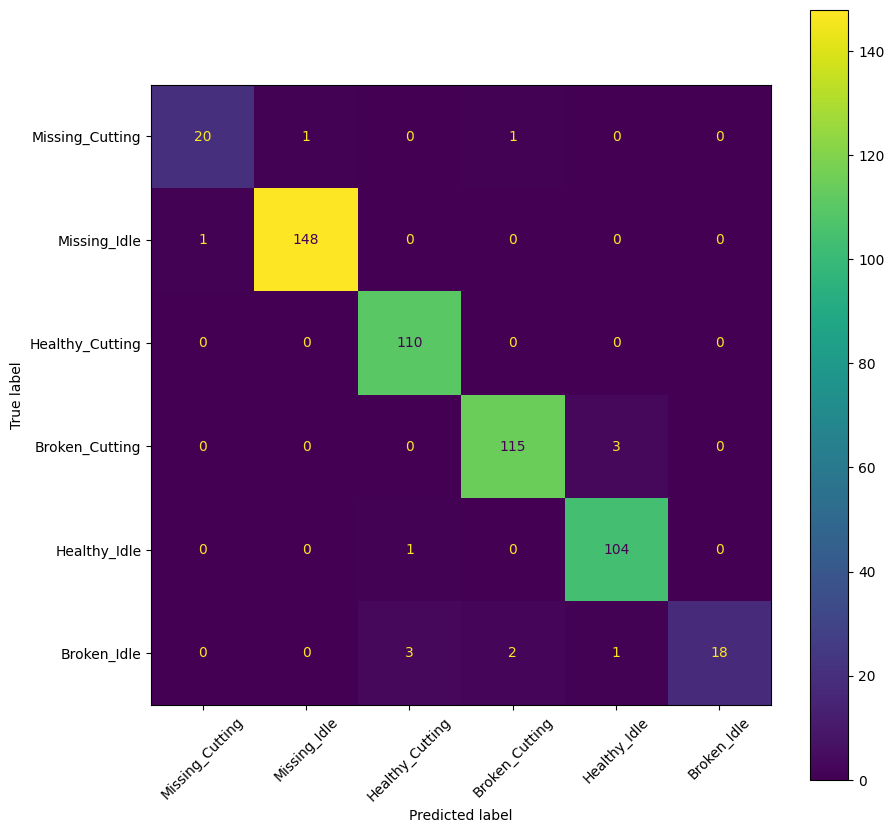

In [75]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_pred = [id_to_label[x] for x in test_results]
y_true = [train_labels[i].iloc[0] for i in range(len(train_labels))]

cm = confusion_matrix(y_true, y_pred, labels=list(label_to_id.keys()))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(label_to_id.keys()))

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.xticks(rotation = 45)
plt.savefig(f'plots/confusion-matrix-model{model_name}-lr{lr}-batch{batch_size}.pth.png')

In [71]:
f'best–lr{lr}-batch{batch_size}-hiddendim{hidden_dim}-numlayer{num_layers}.pth'

'best–lr0.005-batch32-hiddendim8-numlayer8.pth'